# Misura di plateau di efficienza

Questo codice genera un campione di particelle e la risposta di un ipotetico trigger che ha un'efficienza a soglia.

In [1]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
import math

In [2]:
pdf = gamma(3,scale=10)

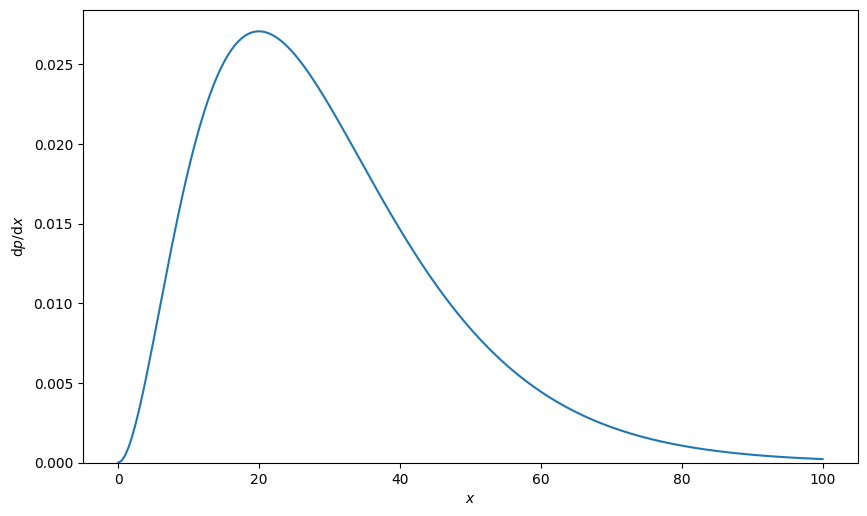

In [3]:
plt.figure(figsize=(10,6), dpi=100)
xs = np.linspace(0,100,200)
ys = pdf.pdf(xs)
plt.plot(xs, ys)
plt.ylim(0)
plt.xlabel('$x$')
plt.ylabel('$\mathrm{d}p/\mathrm{d}x$')
plt.show()

In [4]:
def eff(x):
    return 0.96/(1+np.exp(-0.2*(x-20)))

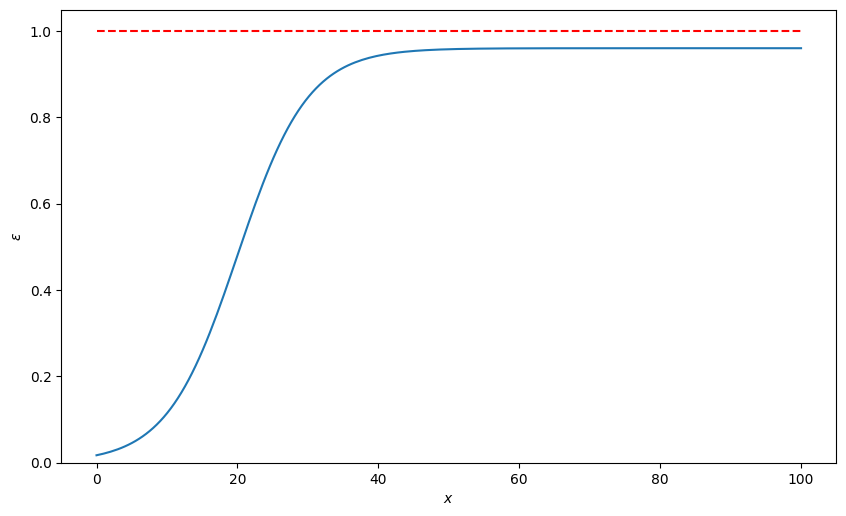

In [5]:
plt.figure(figsize=(10,6), dpi=100)
xs = np.linspace(0,100,200)
ys = eff(xs)
plt.plot(xs, ys)
plt.plot([0,100], [1,1], color='r', linestyle='--')
plt.ylim(0)
plt.xlabel('$x$')
plt.ylabel(r'$\varepsilon$')
plt.show()

In [6]:
x_sample = pdf.rvs(size=10000)

In [7]:
hit_sample = [np.random.random() < eff(x) for x in x_sample]

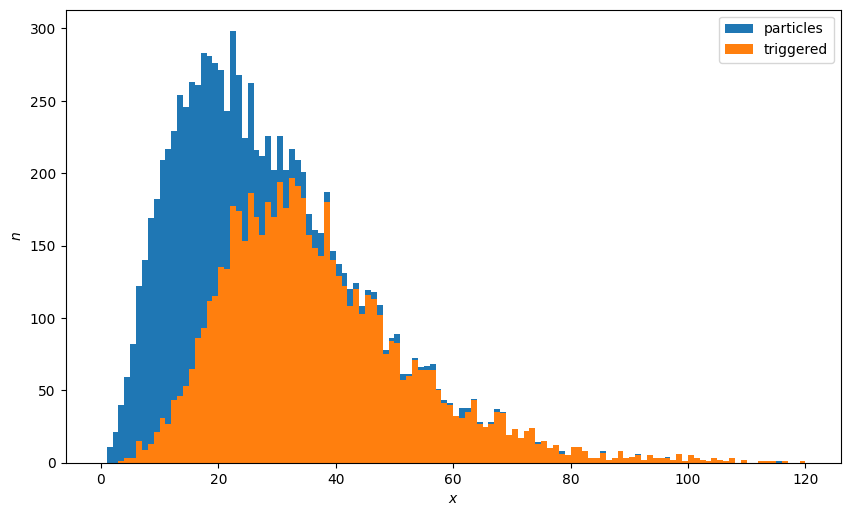

In [8]:
plt.figure(figsize=(10,6), dpi=100)
n_x, bins_x, patches_x = plt.hist(x_sample, label='particles', bins=120, range=(0,120))
n_h, bins_h, patches_h = plt.hist(x_sample[hit_sample], label='triggered', bins=120, range=(0,120))
plt.xlabel('$x$')
plt.ylabel('$n$')
plt.legend()
plt.show()

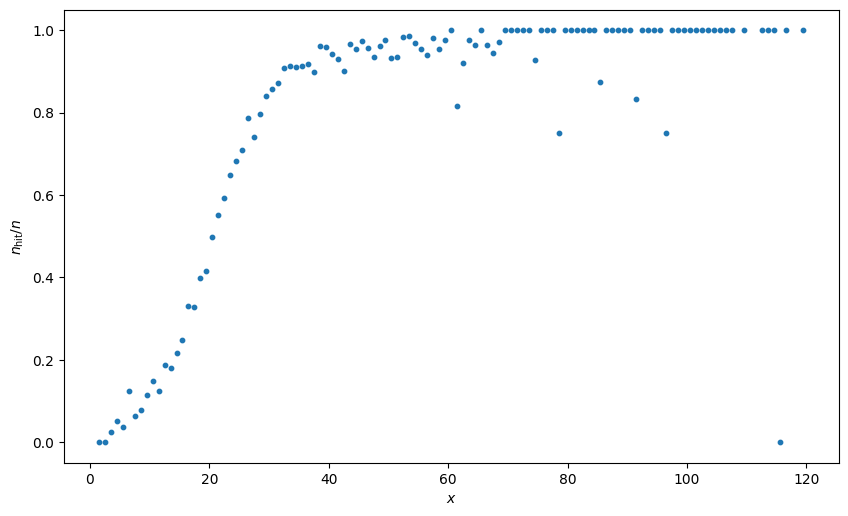

In [21]:
plt.figure(figsize=(10,6), dpi=100)
x_data = bins_x[:-1]+0.5
y_data = np.divide(n_h, n_x, out=np.zeros_like(n_x), where=n_x!=0)
plt.scatter(x_data[n_x>0], y_data[n_x>0], s=10)
plt.xlabel('$x$')
plt.ylabel('$n_{\mathrm{hit}}/n$')
plt.show()

In [10]:
import pandas as pd
data = {'x': x_sample, 'hit': hit_sample}
df = pd.DataFrame(data=data)

In [11]:
df.to_csv('output/trigger.csv')

# Esercizio

A partire da questi dati, misuerare l'andamento dell'efficienza in funzione di $x$ ed in particolare determinare l'efficienza di *plateau* (ossia: asintotica).

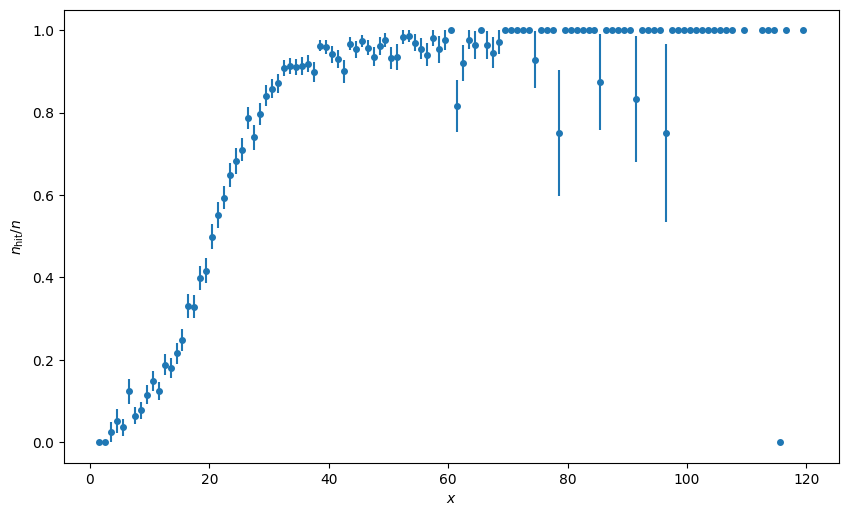

In [42]:
y_err = np.sqrt(np.divide(y_data*(1-y_data), n_x, out=np.zeros_like(n_x), where=n_x!=0))
plt.figure(figsize=(10,6), dpi=100)
plt.errorbar(x_data[n_x>0], y_data[n_x>0], yerr=y_err[n_x>0], fmt="o", markersize=4)
plt.xlabel('$x$')
plt.ylabel('$n_{\mathrm{hit}}/n$')
plt.show()

In [43]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
def model(x, par):
    return par[0]/(1.0+np.exp(-par[1]*(x-par[2])))

In [47]:
least_squares_mode = LeastSquares(x_data[y_err>0], y_data[y_err>0], y_err[y_err>0], model)
m = Minuit(least_squares_mode, (1, 0.1, 20), name=(r"$\varepsilon$", "$a$", "$x_0$"))
m.limits=((0,1), (0,100), (0, 100))

In [48]:
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 51.99                      │              Nfcn = 118              │
│ EDM = 4.07e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\varepsilon$ │   0.967   │   0.004   │            │            │    0    │    1    │       │
│ 1 │ $a$           │   0.201   │   0.006   │            │            │    0    │   100   │       │
│ 2 │ $x_0$         │   20.31   │   0.17    │            │            │    0    │   100   │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬───────────────────────────────────────────┐
│               │ $\varepsilon$           $a$         $x_0$ │
├───────────────┼───────────────────────────────────────────┤
│ $\varepsilon$ │      1.71e-05     -1.06e-05      0.000306 │
│           $a$ │     -1.06e-05      3.14e-05     -0.000192 │
│         $x_0$ │      0.000306     -0.000192        0.0298 │
└───────────────┴───────────────────────────────────────────┘

In [46]:
m.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 39.33                      │              Nfcn = 284              │
│ EDM = 6e-08 (Goal: 0.0002)       │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\varepsilon$ │   0.969   │   0.005   │   -0.005   │   0.005    │    0    │    1    │       │
│ 1 │ $a$           │   0.200   │   0.006   │   -0.006   │   0.006    │    0    │   100   │       │
│ 2 │ $x_0$         │   20.34   │   0.18    │   -0.18    │    0.18    │    0    │   100   │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │     $\varepsilon$     │          $a$          │         $x_0$         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.005   │   0.005   │  -0.006   │   0.006   │   -0.18   │   0.18    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────────┬───────────────────────────────────────────┐
│               │ $\varepsilon$           $a$         $x_0$ │
├───────────────┼───────────────────────────────────────────┤
│ $\varepsilon$ │      2.06e-05     -1.28e-05       0.00037 │
│           $a$ │     -1.28e-05      3.23e-05     -0.000233 │
│         $x_0$ │       0.00037     -0.000233         0.031 │
└───────────────┴───────────────────────────────────────────┘

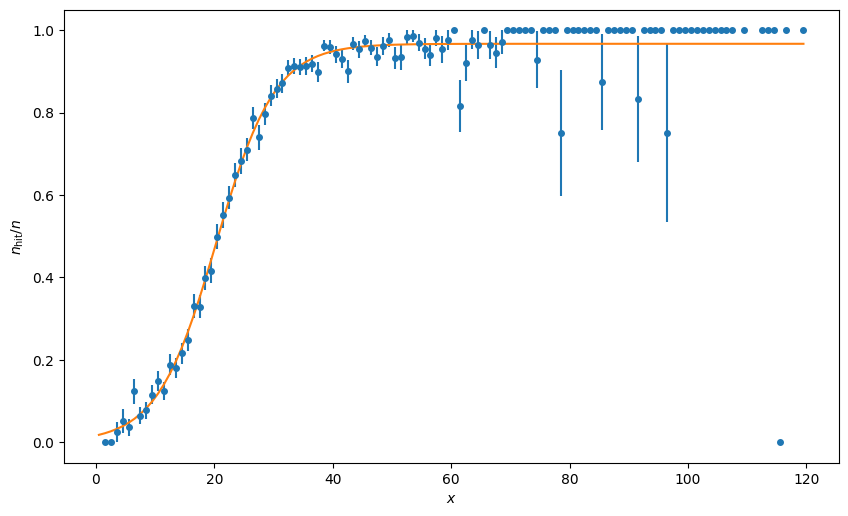

In [25]:
plt.figure(figsize=(10,6), dpi=100)
plt.errorbar(x_data[n_x>0], y_data[n_x>0], yerr=y_err[n_x>0], fmt="o", markersize=4)
plt.plot(x_data, model(x_data, m.values))
plt.xlabel('$x$')
plt.ylabel('$n_{\mathrm{hit}}/n$')
plt.show()

In [26]:
from scipy.stats import binom
def nl_like(par):
    nl = 0
    for x, h, n in zip(x_data, n_h, n_x):
        if n>0:
            eff = par[0]/(1.0+np.exp(-par[1]*(x-par[2])))
            nl -= binom.logpmf(h, n, eff)
    return nl
nl_like.errordef = Minuit.LIKELIHOOD 
m = Minuit(nl_like, (1, 0.1, 20), name=(r"$\varepsilon$", "$a$", "$x_0$"))
m.limits=((0,1), (0,100), (0, 100))
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 184.8                      │              Nfcn = 93               │
│ EDM = 2.57e-08 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\varepsilon$ │   0.961   │   0.004   │            │            │    0    │    1    │       │
│ 1 │ $a$           │   0.200   │   0.006   │            │            │    0    │   100   │       │
│ 2 │ $x_0$         │   20.20   │   0.17    │            │            │    0    │   100   │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────┬───────────────────────────────────────────┐
│               │ $\varepsilon$           $a$         $x_0$ │
├───────────────┼───────────────────────────────────────────┤
│ $\varepsilon$ │      1.67e-05     -9.89e-06      0.000302 │
│           $a$ │     -9.89e-06      3.06e-05     -0.000199 │
│         $x_0$ │      0.000302     -0.000199        0.0305 │
└───────────────┴───────────────────────────────────────────┘

In [19]:
m.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 184.8                      │              Nfcn = 193              │
│ EDM = 2.57e-08 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name          │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $\varepsilon$ │   0.961   │   0.004   │   -0.004   │   0.004    │    0    │    1    │       │
│ 1 │ $a$           │   0.200   │   0.006   │   -0.005   │   0.006    │    0    │   100   │       │
│ 2 │ $x_0$         │   20.20   │   0.17    │   -0.17    │    0.17    │    0    │   100   │       │
└───┴───────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │     $\varepsilon$     │          $a$          │         $x_0$         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.004   │   0.004   │  -0.005   │   0.006   │   -0.17   │   0.17    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────────┬───────────────────────────────────────────┐
│               │ $\varepsilon$           $a$         $x_0$ │
├───────────────┼───────────────────────────────────────────┤
│ $\varepsilon$ │      1.67e-05     -9.89e-06      0.000302 │
│           $a$ │     -9.89e-06      3.06e-05     -0.000199 │
│         $x_0$ │      0.000302     -0.000199        0.0305 │
└───────────────┴───────────────────────────────────────────┘

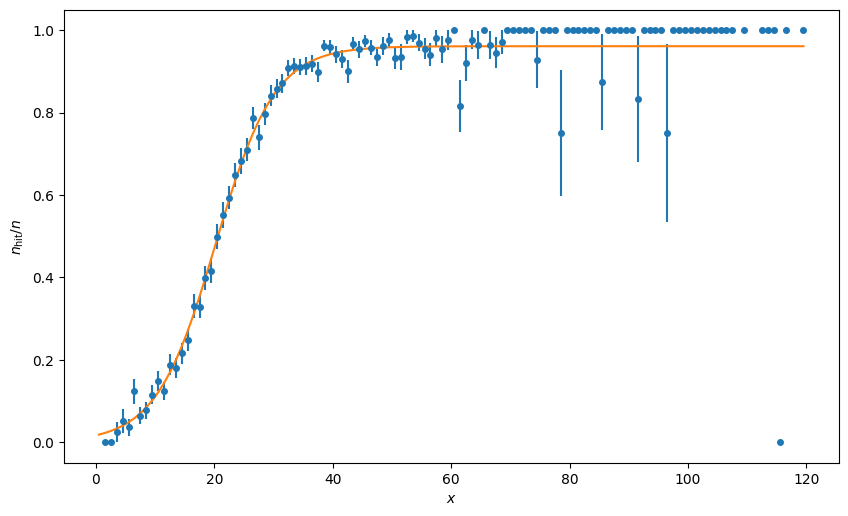

In [20]:
y_err = np.sqrt(np.divide(y_data*(1-y_data), n_x, out=np.zeros_like(n_x), where=n_x!=0))
plt.figure(figsize=(10,6), dpi=100)
plt.errorbar(x_data[n_x>0], y_data[n_x>0], yerr=y_err[n_x>0], fmt="o", markersize=4)
plt.plot(x_data, model(x_data, m.values))
plt.xlabel('$x$')
plt.ylabel('$n_{\mathrm{hit}}/n$')
plt.show()

Text(0, 0.5, '-log L')

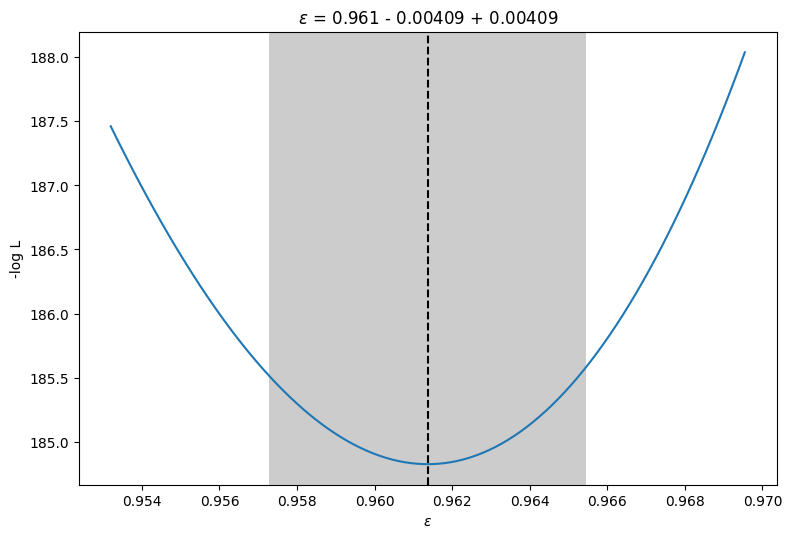

In [29]:
plt.figure(figsize=(9,6), dpi=100)
x, y = m.draw_profile(r"$\varepsilon$")
plt.ylabel('-log L')